In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import backend as K 
import h5py
import os
import sys
import  time
import random
import numpy as np
from tqdm import tqdm
from PIL import Image
import tensorflow as tf
from skimage.io import imread
from keras import backend as K
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.preprocessing.image import  img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import  BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from TV_UNET import get_unet, TV_bin_loss
from tensorflow.keras.metrics import Recall, Precision

2022-02-10 17:24:04.060544: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


<KeysViewHDF5 ['X_train', 'X_valid', 'label_test', 'y', 'y_train', 'y_valid']>


2022-02-10 17:24:04.080072: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-10 17:24:04.080450: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-10 17:24:04.081598: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-10 17:24:04.082767: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

2/2 [==============================] - 0s 132ms/step
[29 16 19 21 25]


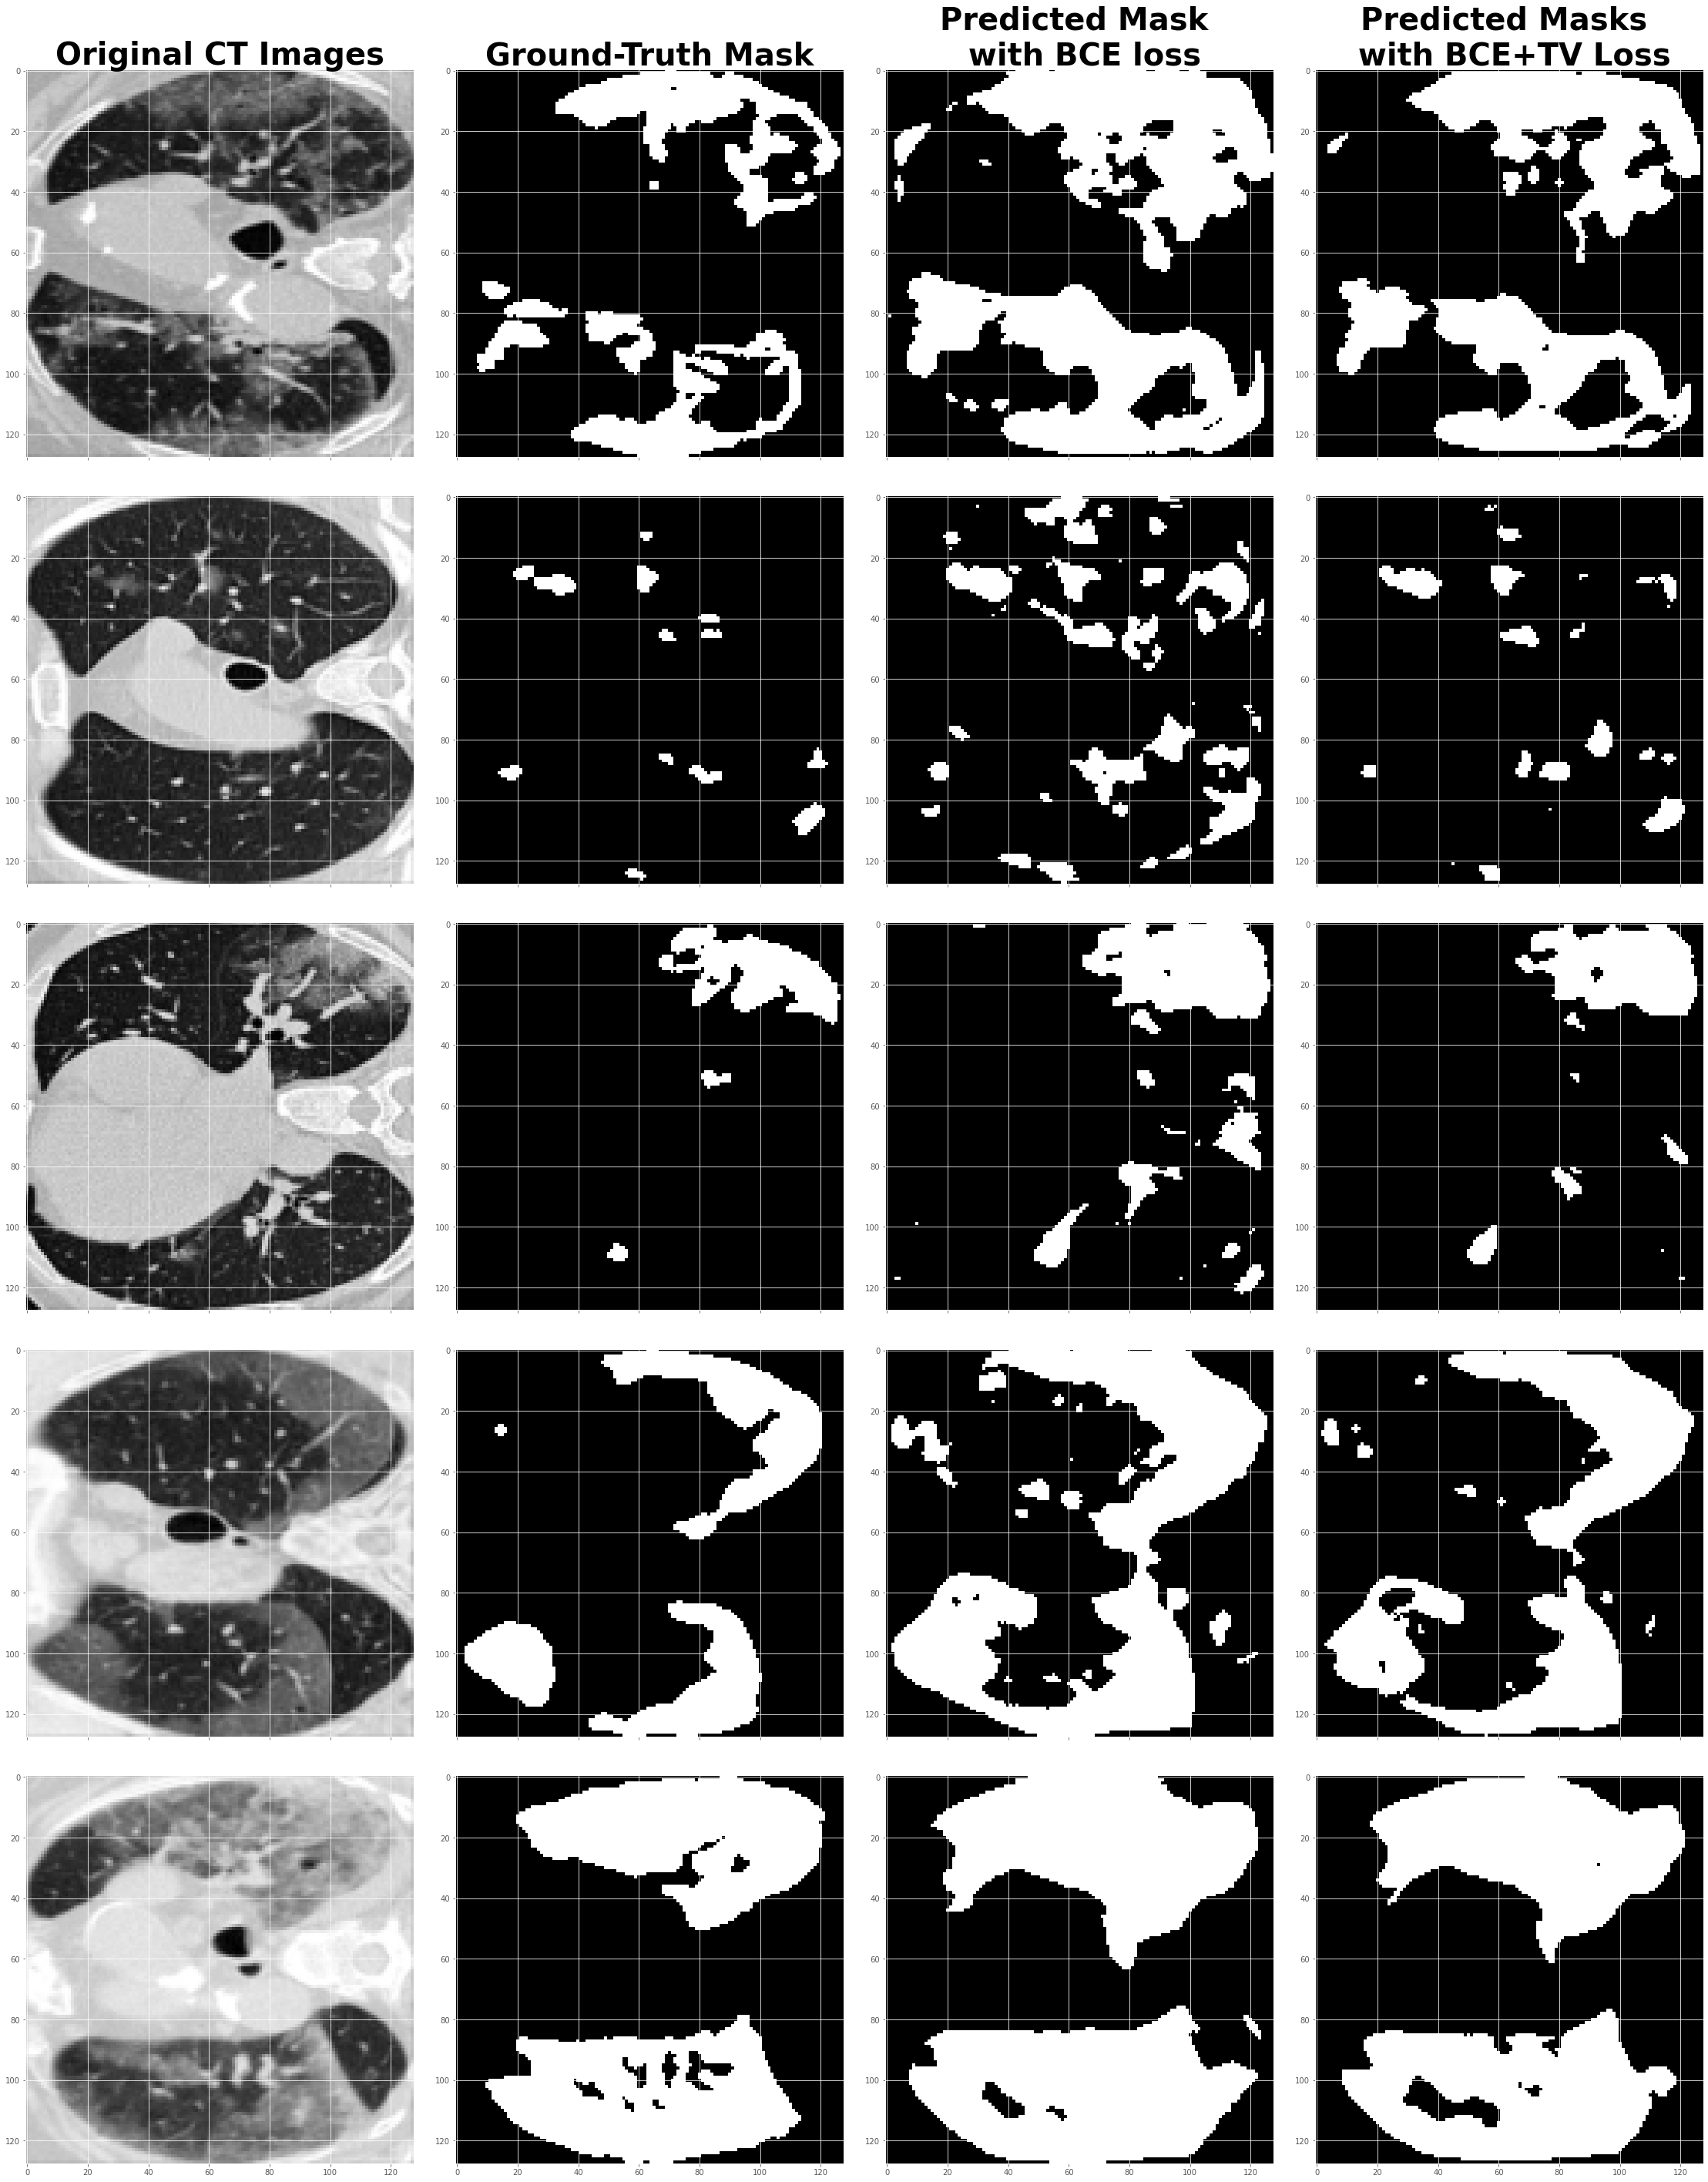

In [2]:
im_width = 128
im_height = 128

input_img = Input((im_height, im_width,1), name='img')
model = get_unet(input_img, n_filters=64, dropout=0.2, batchnorm=True)

model.load_weights("model-TV-UNet1.h5")

combined_data = h5py.File("h5_datasets/combined_CT_datasets.h5", "r")

print(combined_data.keys())

y_train = np.array(combined_data["y_train"])
y_valid = np.array(combined_data["y_valid"])
label_test = np.array(combined_data["label_test"])
y = np.array(combined_data["y"])


# model-TV-UNet1_old.h5
preds_test1 = model.predict(y, verbose=1)
preds_test_t1 = (preds_test1 > 0.1).astype(np.uint8)

#model.load_weights('weight-TV-UNet.h5')
preds_test2 = model.predict(y, verbose=1)
preds_test_t2 = (preds_test2 > 0.3).astype(np.uint8)

no_pred = 5
rand_indx = np.random.randint(1, y.shape[0], no_pred)
print(rand_indx)

def plot_sample(X, y, binary_preds1, binary_preds2):
    fig, axs = plt.subplots(5, 4, figsize=(50, 50),sharex='all')
    i = 0

    for ix in rand_indx:
      l = 1

      axs[i,0].imshow(X[ix, ..., 0], cmap='gray')
      axs[0,0].set_title('Original CT Images',fontweight="bold", size=40)

      axs[i,1].imshow(y[ix,:,:,l].squeeze(),cmap='gray')
      axs[0,1].set_title('Ground-Truth Mask',fontweight="bold", size=40)

      axs[i,2].imshow(binary_preds1[ix,:,:,l].squeeze(),cmap='gray', vmin=0, vmax=1)
      axs[0,2].set_title('Predicted Mask \n with BCE loss',fontweight="bold", size=40)
      
      axs[i,3].imshow(binary_preds2[ix,:,:,l].squeeze(),cmap='gray', vmin=0, vmax=1)
      axs[0,3].set_title('Predicted Masks \n with BCE+TV Loss',fontweight="bold", size=40);
      
      i += 1
      
      plt.rcParams["axes.grid"] = False
      plt.subplots_adjust(wspace=-0.5, hspace=0.1)
    plt.savefig("true_pred_dataset2.png")

plot_sample(y, label_test, preds_test_t1, preds_test_t2)